## Second set of test runs - basic simulations, dense fields where PSFs are known perfectly but there is a systematic 0.3-pixel astrometric offset between images.

In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd
import multiprocessing
from joblib import Parallel, delayed
num_cores = multiprocessing.cpu_count()
if num_cores == 32:
    num_cores = 16
elif num_cores == 8:
    num_cores = 3
elif num_cores == 4:
    num_cores = 2
print num_cores

import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)

class sizeme():
    """ Class to change html fontsize of object's representation"""
    def __init__(self,ob, size=50, height=120):
        self.ob = ob
        self.size = size
        self.height = height
    def _repr_html_(self):
        repl_tuple = (self.size, self.height, self.ob._repr_html_())
        return u'<span style="font-size:{0}%; line-height:{1}%">{2}</span>'.format(*repl_tuple)

pd.options.display.max_columns = 9999
pd.set_option('display.width', 9999)

16


In [3]:
import diffimTests as dit
reload(dit)

# Let's try w same parameters as ZOGY paper.
sky = 300.

n_sources = 2500

testObj = dit.DiffimTest(imSize=(512,512), sky=sky, offset=[0.3,0.3], psf_yvary_factor=0., 
                         #varSourceChange=[1500., 1600., 1800., 2000., 2200., 2400., 2600., 2800.],
                         varFlux2=[1500., 1500., 1500.], variablesNearCenter=False,
                         theta1=0., theta2=-45., im2background=0., n_sources=n_sources, sourceFluxRange=(500,30000), 
                         seed=66, psfSize=13)

print dit.computeClippedImageStats(testObj.im1.im)
print dit.computeClippedImageStats(testObj.im2.im)
print dit.computeClippedImageStats(testObj.im1.var)
print dit.computeClippedImageStats(testObj.im2.var)

diffimTests.py:231: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  (offset2[0]-starSize+1):(offset2[0]+starSize)] += tmp1
diffimTests.py:256: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  (offset2[0]-starSize+1):(offset2[0]+starSize)] += tmp


(7.5967275689784346, 22.904165312892815, -70.494936069740646, 3654.989393726783)
(14.988638238640887, 30.512347231621803, -81.346487999439063, 2639.0207819341863)
(307.59672756897845, 22.904165312892811, 229.50506393025935, 3954.989393726783)
(314.98863823864087, 30.512347231621799, 218.65351200056094, 2939.0207819341863)


In [4]:
src = testObj.runTest(returnSources=True)

In [5]:
changedCentroid = np.array(testObj.centroids[testObj.changedCentroidInd, :])
print changedCentroid

#print src['AL'][['base_NaiveCentroid_x', 'base_NaiveCentroid_y', 'base_PsfFlux_fluxSigma', 'base_PsfFlux_flag']]
for key in ['ALstack', 'ZOGY', 'SZOGY', 'ALstack_noDecorr']:
    print key
    if key is not 'SZOGY':
        fsKey = 'base_PsfFlux_fluxSigma'
    else: # For SZOGY, the correct flux measurement is PeakLikelihoodFlux
        fsKey = 'base_PeakLikelihoodFlux_fluxSigma'
    print src[key][['base_NaiveCentroid_x', 'base_NaiveCentroid_y', fsKey, 'base_PsfFlux_flag']]

[[  165.15463891    60.92011564     0.          1500.        ]
 [   40.8754355    415.99091391     0.          1500.        ]
 [  186.45621549   397.17030423     0.          1500.        ]]
ALstack
   base_NaiveCentroid_x  base_NaiveCentroid_y  base_PsfFlux_fluxSigma base_PsfFlux_flag
0            165.026706             61.020390              262.647971             False
1            186.554865            397.242145              210.022306             False
ZOGY
     base_NaiveCentroid_x  base_NaiveCentroid_y  base_PsfFlux_fluxSigma base_PsfFlux_flag
0              364.088317             40.208593              290.780648             False
1              248.813553             40.101316              331.230652             False
2              447.163395             41.220938              271.619128             False
6              269.527574             58.164515              160.394000             False
7              405.257694             53.380337              247.445632            

In [8]:
reload(dit)

# Let's try w same parameters as ZOGY paper.
sky = 300.

testObj = dit.DiffimTest(imSize=(512,512), sky=sky, offset=[0.3,0.3], psf_yvary_factor=0., 
                         varFlux2=[1500., 1600., 1800., 2000., 2200., 2400., 2600., 2800.],
                         theta1=0., theta2=-45., im2background=0., n_sources=n_sources, sourceFluxRange=(500,30000), 
                         seed=66, psfSize=13)

det = testObj.runTest()
print det

{'ZOGY': {'FP': 45, 'FN': 0, 'TP': 8}, 'ALstack': {'FP': 0, 'FN': 0, 'TP': 8}, 'SZOGY': {'FP': 1, 'FN': 0, 'TP': 8}, 'ALstack_noDecorr': {'FP': 0, 'FN': 0, 'TP': 8}}


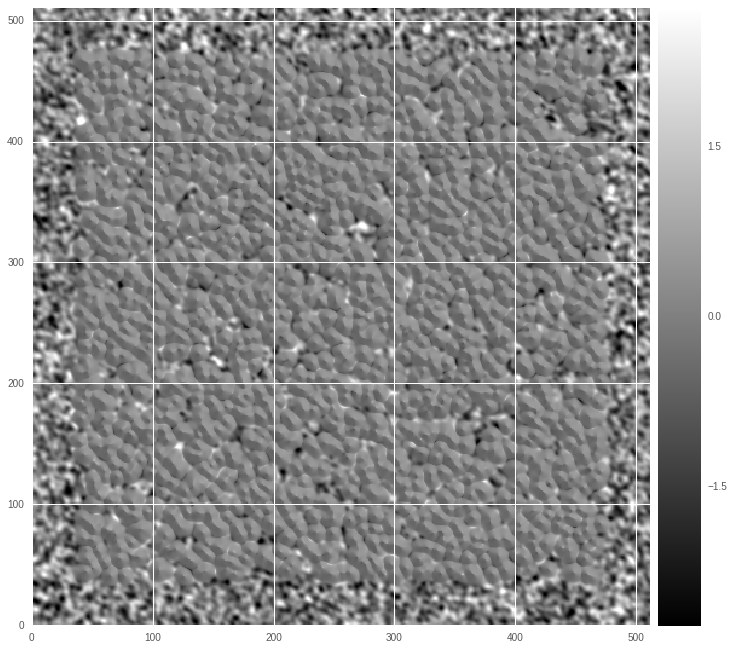

In [14]:
fig = plt.figure(1, (12, 12))
dit.plotImageGrid((testObj.S_corr_ZOGY.im,))

Try some real tests!

In [7]:
# Default 10 sources with same flux
def runTest(flux, seed=66, sky=300., n_sources=50, n_varSources=1):
    #methods = ['ALstack', 'ZOGY', 'ZOGY_S', 'ALstack_noDecorr']
    testObj = dit.DiffimTest(imSize=(512,512), sky=sky, offset=[0.3,0.3], psf_yvary_factor=0., 
                             varFlux2=np.repeat(flux, n_varSources), variablesNearCenter=False,
                             theta1=0., theta2=-45., im2background=0., n_sources=n_sources, 
                             sourceFluxRange=(500,30000), seed=seed, psfSize=13)
    det = testObj.runTest() #subtractMethods=methods) #, 'AL'])
    det['flux'] = flux
    return det

methods = ['ALstack', 'ZOGY', 'SZOGY', 'ALstack_noDecorr']

## Look at detection rates for 5.0-sigma sources.

In [8]:
inputs = [(f, seed) for f in [1500] for seed in np.arange(66, 166, 1)]
print len(inputs)
testResults1 = Parallel(n_jobs=num_cores, verbose=2)(delayed(runTest)(i[0], i[1], n_sources=n_sources, n_varSources=10) \
                                                     for i in inputs)

100


[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:   23.6s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:  2.3min finished


FN: 
ALstack              0.61
ALstack_noDecorr     0.40
SZOGY               10.00
ZOGY                 9.46
dtype: float64
FP: 
ALstack               0.68
ALstack_noDecorr      0.89
SZOGY                 0.00
ZOGY                257.04
dtype: float64
TP: 
ALstack             9.39
ALstack_noDecorr    9.60
SZOGY               0.00
ZOGY                0.54
dtype: float64


(-1, 4)

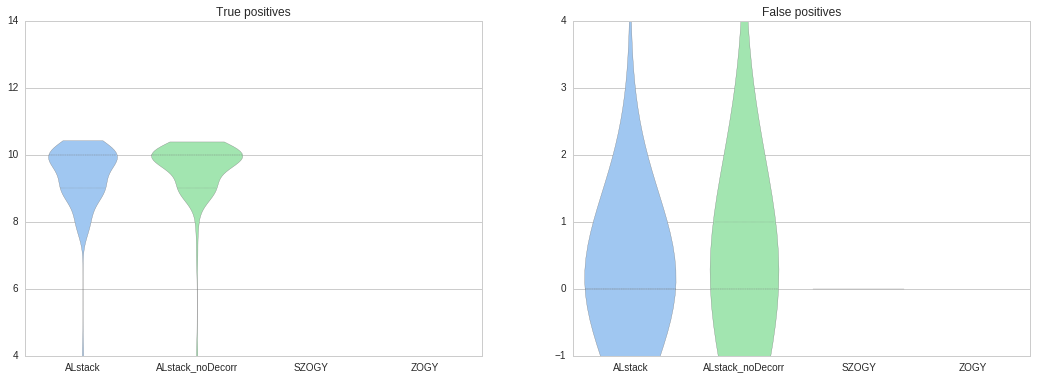

In [11]:
tr = testResults1
FN = pd.DataFrame({key: np.array([t[key]['FN'] for t in tr]) for key in methods})
FP = pd.DataFrame({key: np.array([t[key]['FP'] for t in tr]) for key in methods})
TP = pd.DataFrame({key: np.array([t[key]['TP'] for t in tr]) for key in methods})
print 'FN:', '\n', FN.mean()
print 'FP:', '\n', FP.mean()
print 'TP:', '\n', TP.mean()

matplotlib.rcParams['figure.figsize'] = (18.0, 6.0)
fig, axes = plt.subplots(nrows=1, ncols=2)

sns.violinplot(data=TP, inner="quart", cut=True, linewidth=0.3, bw=0.5, ax=axes[0])
axes[0].set_title('True positives')
axes[0].set_ylim((4, 14))
sns.violinplot(data=FP, inner="quart", cut=True, linewidth=0.3, bw=0.5, ax=axes[1])
axes[1].set_title('False positives')
axes[1].set_ylim((-1, 4))

## Look at detection rates for 3.33-sigma sources.

In [12]:
inputs = [(f, seed) for f in [1000] for seed in np.arange(66, 166, 1)]
print len(inputs)
testResults2 = Parallel(n_jobs=num_cores, verbose=2)(delayed(runTest)(i[0], i[1], n_sources=100, n_varSources=10) \
                                                     for i in inputs)

100


[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  4.3min
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed: 11.2min finished


FN: 
ALstack             2.66
ALstack_noDecorr    2.42
SZOGY               1.80
ZOGY                2.82
dtype: float64
FP: 
ALstack               0.82
ALstack_noDecorr      0.65
SZOGY                 0.33
ZOGY                117.39
dtype: float64
TP: 
ALstack             7.32
ALstack_noDecorr    7.56
SZOGY               8.17
ZOGY                7.16
dtype: float64


(-1, 4)

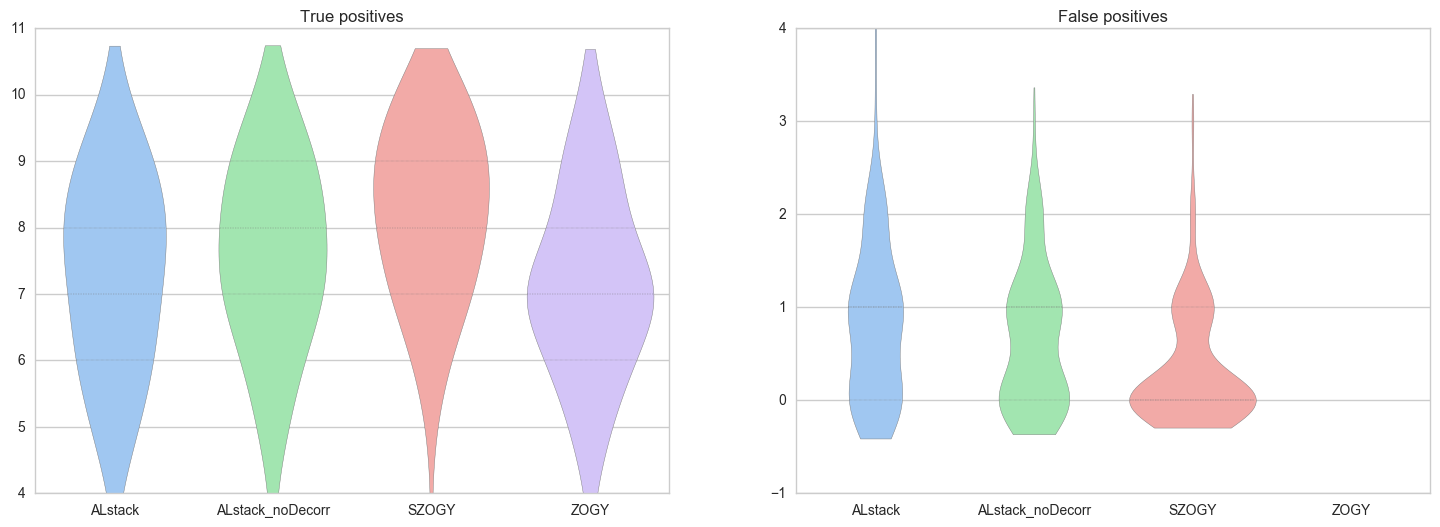

In [25]:
tr = testResults2
FN = pd.DataFrame({key: np.array([t[key]['FN'] for t in tr]) for key in methods})
FP = pd.DataFrame({key: np.array([t[key]['FP'] for t in tr]) for key in methods})
TP = pd.DataFrame({key: np.array([t[key]['TP'] for t in tr]) for key in methods})
print 'FN:', '\n', FN.mean()
print 'FP:', '\n', FP.mean()
print 'TP:', '\n', TP.mean()

matplotlib.rcParams['figure.figsize'] = (18.0, 6.0)
fig, axes = plt.subplots(nrows=1, ncols=2)

sns.violinplot(data=TP, inner="quart", cut=True, linewidth=0.3, bw=0.5, ax=axes[0])
axes[0].set_title('True positives')
axes[0].set_ylim((4, 11))
sns.violinplot(data=FP, inner="quart", cut=True, linewidth=0.3, bw=0.5, ax=axes[1])
axes[1].set_title('False positives')
axes[1].set_ylim((-1, 4))

## For fun, try some 10-sigma sources.

In [19]:
inputs = [(f, seed) for f in [3000] for seed in np.arange(66, 166, 1)]
print len(inputs)
testResults3 = Parallel(n_jobs=num_cores, verbose=2)(delayed(runTest)(i[0], i[1], n_sources=100, n_varSources=10) \
                                                     for i in inputs)

100


[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  4.1min
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed: 11.0min finished


FN: 
ALstack             2.04
ALstack_noDecorr    1.97
SZOGY               1.49
ZOGY                1.96
dtype: float64
FP: 
ALstack               0.07
ALstack_noDecorr      0.08
SZOGY                 0.32
ZOGY                116.41
dtype: float64
TP: 
ALstack             7.94
ALstack_noDecorr    8.00
SZOGY               8.48
ZOGY                8.02
dtype: float64


(-1, 4)

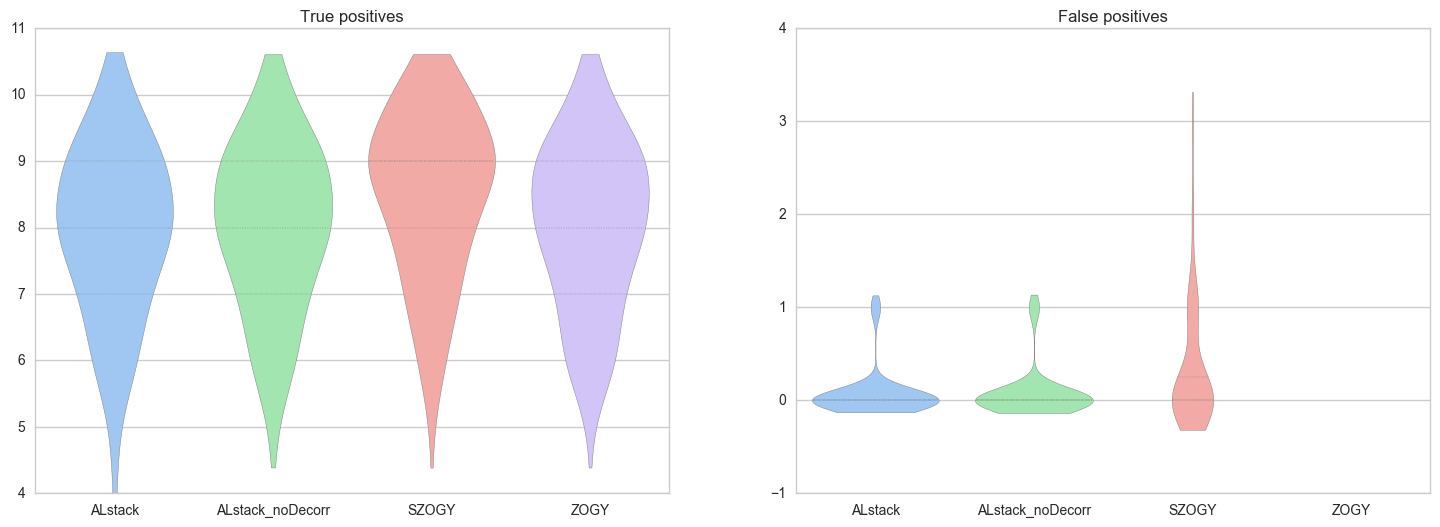

In [26]:
tr = testResults3
FN = pd.DataFrame({key: np.array([t[key]['FN'] for t in tr]) for key in methods})
FP = pd.DataFrame({key: np.array([t[key]['FP'] for t in tr]) for key in methods})
TP = pd.DataFrame({key: np.array([t[key]['TP'] for t in tr]) for key in methods})
print 'FN:', '\n', FN.mean()
print 'FP:', '\n', FP.mean()
print 'TP:', '\n', TP.mean()

matplotlib.rcParams['figure.figsize'] = (18.0, 6.0)
fig, axes = plt.subplots(nrows=1, ncols=2)

sns.violinplot(data=TP, inner="quart", cut=True, linewidth=0.3, bw=0.5, ax=axes[0])
axes[0].set_title('True positives')
axes[0].set_ylim((4, 11))
sns.violinplot(data=FP, inner="quart", cut=True, linewidth=0.3, bw=0.5, ax=axes[1])
axes[1].set_title('False positives')
axes[1].set_ylim((-1, 4))